# Multi-Resolution Component Separation with HEALPix ud_grade

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CMBSciPol/furax-compsep-paper/blob/main/notebooks/03_PTEP_Multi_Resolution_Component_Separation.ipynb)

## Learning Objectives

By the end of this notebook, you will:
- Understand multi-resolution component separation using HEALPix ud_grade
- Implement resolution-based parameter optimization for CMB analysis
- Optimize spectral parameters at different spatial scales
- Visualize how resolution-based parameterization improves computational efficiency

## The Multi-Resolution Approach

Traditional component separation uses uniform resolution across all parameters. The PTEP (LiteBIRD Physics, Technology, and Engineering Plan) approach recognizes that different astrophysical parameters vary at different spatial scales. This method uses HEALPix `ud_grade` to downsample parameter maps to appropriate resolutions.

**Key Innovation**: Optimize spectral parameters at resolution scales matched to their astrophysical variation, reducing computational cost while maintaining accuracy.

In [16]:
# Setup and Data Loading

import os
os.environ["EQX_ON_ERROR"] = "nan"
os.environ["JAX_PLATFORM_NAME"] = "cpu"

# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from functools import partial

# JAX ecosystem
import jax
import jax.numpy as jnp
import jax.random as jr
import optax
from jax_grid_search import ProgressBar, optimize
from rich.progress import BarColumn, TimeElapsedColumn, TimeRemainingColumn

# FURAX framework
from furax import HomothetyOperator
from furax.obs import negative_log_likelihood, sky_signal
from furax.obs.stokes import Stokes

# JAX-HEALPix for mask and map operations
from jax_healpy.clustering import (
    get_cutout_from_mask, get_fullmap_from_cutout
)

# Data utilities
import sys
sys.path.append("../data")
from generate_maps import get_mask, load_from_cache, save_to_cache
from instruments import get_instrument

# Configure JAX
jax.config.update("jax_enable_x64", True)

# Load CMB and foreground data
nside = 64
npixels = 12 * nside**2

# Generate and load multi-frequency data
save_to_cache(nside, sky="c1d1s1", noise=False)
nu, freq_maps = load_from_cache(nside, sky="c1d1s1", noise=False)
print(f"Frequency maps shape: {freq_maps.shape}")
print(f"Frequencies: {len(nu)} bands from {nu[0]:.0f} to {nu[-1]:.0f} GHz")

# Convert to FURAX format (Q,U polarization)
d = Stokes.from_stokes(Q=freq_maps[:, 1, :], U=freq_maps[:, 2, :])

# Load galactic mask (cleanest 20% of sky)
mask = get_mask("GAL020", nside=nside)
(indices,) = jnp.where(mask == 1)
coverage = jnp.mean(mask) * 100
print(f"Sky coverage: {coverage:.1f}% ({len(indices):,} pixels)")

# Extract masked data for computation
masked_d = get_cutout_from_mask(d, indices, axis=1)
print(f"Masked data shape: {masked_d.shape}")

Loaded freq_maps for nside 64 from cache and noise False.
Loaded freq_maps for nside 64 from cache.
Frequency maps shape: (15, 3, 49152)
Frequencies: 15 bands from 40 to 402 GHz
Sky coverage: 19.7% (9,695 pixels)
Masked data shape: (15, 9695)


In [ ]:
# Multi-Resolution Patch Generation

# Configure resolution parameters for different spectral indices
target_ud_grade = [64, 32, 16]  # Target nside values for [beta_dust, temp_dust, beta_pl]
ud_beta_d = int(target_ud_grade[0])    # Dust spectral index resolution
ud_temp_d = int(target_ud_grade[1])    # Dust temperature resolution  
ud_beta_pl = int(target_ud_grade[2])   # Synchrotron spectral index resolution

print(f"Multi-resolution configuration:")
print(f"  Dust spectral index (beta_dust): nside={ud_beta_d} ({12*ud_beta_d**2:,} pixels)")
print(f"  Dust temperature (temp_dust): nside={ud_temp_d} ({12*ud_temp_d**2:,} pixels)")
print(f"  Synchrotron index (beta_pl): nside={ud_beta_pl} ({12*ud_beta_pl**2:,} pixels)")

# Create pixel index arrays for ud_grade operations
npix = nside**2 * 12
ipix = np.arange(npix)

def ud_grade(ipix, nside_in, nside_out):
    """Downgrade and upgrade pixel indices to create resolution patches."""
    if nside_out == 0:
        return np.zeros_like(ipix)
    else:
        # Downgrade to target resolution then upgrade back to original
        lowered = hp.ud_grade(ipix, nside_out=nside_out)
        return hp.ud_grade(lowered, nside_out=nside_in)

# Generate resolution-based patch indices
print("\nGenerating multi-resolution patches...")
ud_beta_d_map = ud_grade(ipix, nside, ud_beta_d)
ud_temp_d_map = ud_grade(ipix, nside, ud_temp_d) 
ud_beta_pl_map = ud_grade(ipix, nside, ud_beta_pl)

# Create patch index dictionary
patch_indices = {
    "beta_dust_patches": ud_beta_d_map,
    "temp_dust_patches": ud_temp_d_map,
    "beta_pl_patches": ud_beta_pl_map,
}

# Extract masked patches and normalize indices
masked_patches = get_cutout_from_mask(patch_indices, indices)

def normalize_array(arr):
    """Normalize patch indices for consistent indexing."""
    unique_vals, indices_norm = np.unique(arr, return_inverse=True)
    return indices_norm

masked_patches = jax.tree.map(normalize_array, masked_patches)
masked_patches = jax.tree.map(lambda x: x.astype(jnp.int64), masked_patches)

# Count unique patches for each parameter
max_count = {
    "beta_dust": np.unique(masked_patches["beta_dust_patches"]).size,
    "temp_dust": np.unique(masked_patches["temp_dust_patches"]).size,
    "beta_pl": np.unique(masked_patches["beta_pl_patches"]).size,
}

print(f"Resolution patch counts:")
for param, count in max_count.items():
    print(f"  {param}: {count} patches")


# Visualize Clusters

Consider using `from jax_healpy.clustering._clustering import shuffle_labels` to shuffle cluster labels for better visualization.


/tmp/ipykernel_81717/3240274331.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


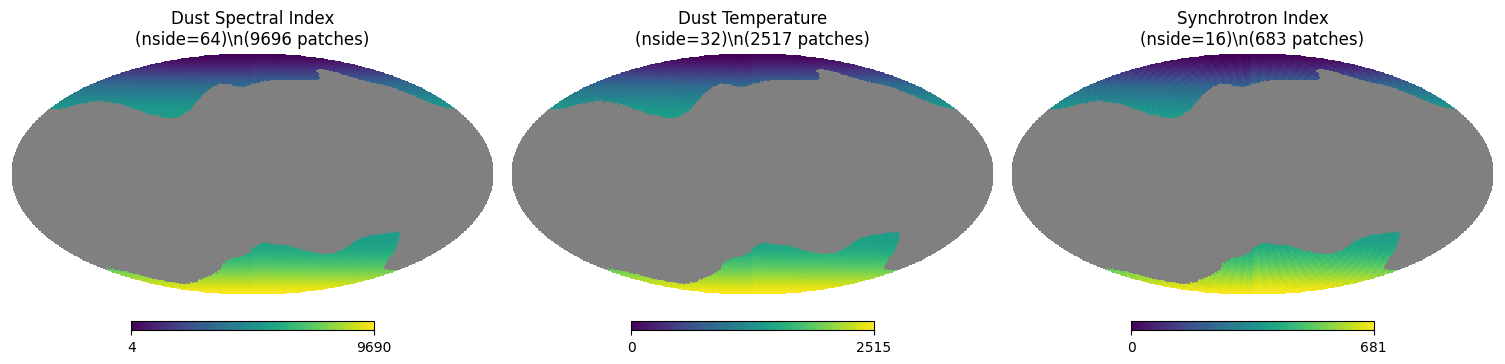

Multi-resolution patches ready for optimization


In [26]:
# Visualize the multi-resolution patches
fig = plt.figure(figsize=(15, 5))

param_labels = ['Dust Spectral Index\n(nside=64)', 'Dust Temperature\n(nside=32)', 'Synchrotron Index\n(nside=16)']
patch_maps = get_fullmap_from_cutout(masked_patches, indices , nside=nside)
patch_maps = [patch_maps['beta_dust_patches'], patch_maps['temp_dust_patches'], patch_maps['beta_pl_patches']]

for i, (label, patch_map) in enumerate(zip(param_labels, patch_maps)):
    n_unique = np.unique(patch_map).size
    
    hp.mollview(
        patch_map,
        title=f'{label}\\n({n_unique} patches)',
        sub=(1, 3, i+1),
        bgcolor=(0.0,)*4
    )

plt.tight_layout()
plt.show()

print("Multi-resolution patches ready for optimization")

In [23]:
# Parameter Optimization

# Setup optimization parameters
dust_nu0 = 160.0      # Dust reference frequency (GHz)
synchrotron_nu0 = 20.0  # Synchrotron reference frequency (GHz)

# Create objective function with fixed reference frequencies
negative_log_likelihood_fn = partial(
    negative_log_likelihood, 
    dust_nu0=dust_nu0, 
    synchrotron_nu0=synchrotron_nu0
)

sky_signal_fn = partial(
    sky_signal,
    dust_nu0=dust_nu0,
    synchrotron_nu0=synchrotron_nu0
)

# Initialize parameters for each resolution level (realistic starting values)
base_params = {
    "beta_dust": 1.54,   # Dust spectral index
    "temp_dust": 20.0,   # 20K dust temperature
    "beta_pl": -3.0,     # Synchrotron index
}

initial_params = jax.tree.map(lambda v, c: jnp.full((c,), v), base_params, max_count)

print("Parameter initialization:")
for param, values in initial_params.items():
    print(f"  {param}: {len(values)} patches at resolution, initial value = {values[0]}")

# Create noise operator (simplified for demonstration)
N = HomothetyOperator(jnp.ones(1), _in_structure=masked_d.structure)

# Setup L-BFGS optimizer
solver = optax.lbfgs()

print("\\nRunning multi-resolution optimization...")
print("This may take a few minutes...")

# Progress bar setup
progress_columns = [
    "[progress.description]{task.description}",
    BarColumn(),
    "[progress.percentage]{task.percentage:>3.0f}%",
    TimeElapsedColumn(),
    TimeRemainingColumn(),
]

# Run optimization with progress bar
with ProgressBar(*progress_columns) as p:
    final_params, final_state = optimize(
        initial_params,
        negative_log_likelihood_fn,
        solver,
        max_iter=100,  # Reduced for demo
        tol=1e-6,
        progress=p,
        nu=nu,
        N=N,
        d=masked_d,
        patch_indices=masked_patches,
    )

# Show optimization results
print(f"\\nOptimization completed!")
print(f"Iterations: {final_state.count}")
print(f"Final function value: {final_state.value:.2e}")

# Display optimized parameter statistics
print("\\nOptimized parameter ranges:")
for param, values in final_params.items():
    resolution_info = {
        'beta_dust': f'nside={ud_beta_d}',
        'temp_dust': f'nside={ud_temp_d}', 
        'beta_pl': f'nside={ud_beta_pl}'
    }
    print(f"  {param} ({resolution_info[param]}): [{jnp.min(values):.3f}, {jnp.max(values):.3f}], "
          f"mean = {jnp.mean(values):.3f} ± {jnp.std(values):.3f}")

# Compute CMB reconstruction with optimized parameters
reconstructed_signal = sky_signal_fn(
    final_params, nu=nu, d=masked_d, N=N, patch_indices=masked_patches
)
cmb_reconstruction = reconstructed_signal["cmb"]
print(f"\\nCMB reconstruction completed")
print(f"CMB shape: Q={cmb_reconstruction.q.shape}, U={cmb_reconstruction.u.shape}")

Output()

Parameter initialization:
  beta_dust: 9695 patches at resolution, initial value = 1.54
  beta_pl: 682 patches at resolution, initial value = -3.0
  temp_dust: 2516 patches at resolution, initial value = 20.0
\nRunning multi-resolution optimization...
This may take a few minutes...


\nOptimization completed!
Iterations: <built-in method count of OptimizerState object at 0x72961c5eaff0>
Final function value: -2.02e+07
\nOptimized parameter ranges:
  beta_dust (nside=64): [1.308, 1.795], mean = 1.635 ± 0.045
  beta_pl (nside=16): [-3.216, -2.796], mean = -3.019 ± 0.054
  temp_dust (nside=32): [19.794, 20.097], mean = 20.017 ± 0.014
\nCMB reconstruction completed
CMB shape: Q=(9695,), U=(9695,)


In [24]:
# Parameter Map Reconstruction

# Map resolution parameters back to full sky maps
print("Reconstructing full-sky parameter maps...")

param_maps = {}
for param_name in ['temp_dust', 'beta_dust', 'beta_pl']:
    # Get optimized parameter values for each resolution patch
    param_values = final_params[param_name]
    patch_indices_param = masked_patches[f"{param_name}_patches"]
    
    # Map parameter values to masked pixels using patch assignments
    param_map_masked = param_values[patch_indices_param]
    
    # Convert back to full HEALPix map
    full_param_map = get_fullmap_from_cutout(param_map_masked, indices, nside=nside)
    param_maps[param_name] = full_param_map

print("Parameter map reconstruction completed!")

# Also reconstruct CMB maps for visualization
cmb_q_full = get_fullmap_from_cutout(cmb_reconstruction.q, indices, nside=nside)
cmb_u_full = get_fullmap_from_cutout(cmb_reconstruction.u, indices, nside=nside)

print(f"CMB maps reconstructed to full sky")
print(f"Parameter maps available: {list(param_maps.keys())}")

# Display parameter statistics with resolution info
print("\\nFull-sky parameter statistics:")
resolution_info = {
    'temp_dust': f'nside={ud_temp_d}',
    'beta_dust': f'nside={ud_beta_d}',
    'beta_pl': f'nside={ud_beta_pl}'
}

for param_name, param_map in param_maps.items():
    valid_data = param_map[param_map != hp.UNSEEN]
    if len(valid_data) > 0:
        print(f"  {param_name} ({resolution_info[param_name]}): [{jnp.min(valid_data):.3f}, {jnp.max(valid_data):.3f}], "
              f"mean = {jnp.mean(valid_data):.3f} ± {jnp.std(valid_data):.3f}")
    else:
        print(f"  {param_name}: No valid data")

Reconstructing full-sky parameter maps...
Parameter map reconstruction completed!
CMB maps reconstructed to full sky
Parameter maps available: ['temp_dust', 'beta_dust', 'beta_pl']
\nFull-sky parameter statistics:
  temp_dust (nside=32): [19.794, 20.097], mean = 20.017 ± 0.014
  beta_dust (nside=64): [1.308, 1.795], mean = 1.635 ± 0.045
  beta_pl (nside=16): [-3.216, -2.796], mean = -3.021 ± 0.054


/tmp/ipykernel_81717/1737064389.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


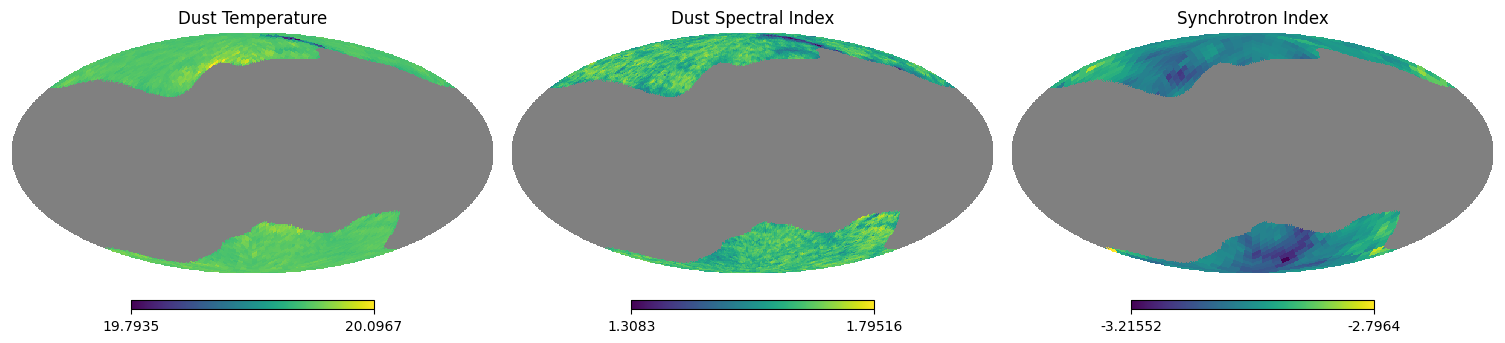

In [25]:
# Results Visualization
fig = plt.figure(figsize=(15, 5))

# Plot the three parameter maps only
hp.mollview(
    param_maps['temp_dust'],
    title='Dust Temperature',
    sub=(1, 3, 1),
    bgcolor=(0.0,)*4
)

hp.mollview(
    param_maps['beta_dust'], 
    title='Dust Spectral Index',
    sub=(1, 3, 2),
    bgcolor=(0.0,)*4
)

hp.mollview(
    param_maps['beta_pl'],
    title='Synchrotron Index', 
    sub=(1, 3, 3),
    bgcolor=(0.0,)*4
)

plt.tight_layout()
plt.show()

## Command-Line Tool for Large-Scale Analysis

The complete workflow demonstrated above is implemented in the production script `05-PTEP-model.py` for large-scale analysis on HPC clusters.

### Basic Usage

```bash
# Run multi-resolution PTEP component separation
cd content/
python 05-PTEP-model.py -n 64 -ud 64 32 16 -tag c1d1s1 -m GAL020 -i LiteBIRD
```

### Key Parameters

- `-n 64`: HEALPix resolution (nside=64 → ~55 arcmin pixels)
- `-ud 64 32 16`: Target nside values for [dust_beta, dust_temp, sync_beta] resolutions
- `-tag c1d1s1`: Sky simulation (CMB + dust + synchrotron)
- `-m GAL020`: Galactic mask (20% cleanest sky)
- `-i LiteBIRD`: Instrument configuration

### Output Structure

Results are saved to `results/PTEP_{config}_BD{ud1}_TD{ud2}_BS{ud3}_{instrument}_{mask}_{noise}/`:
- `best_params.npz`: Optimized spectral parameters per resolution
- `results.npz`: Full optimization results with resolution patches
- `mask.npy`: Sky mask used for analysis

### Scaling to Large Problems

The command-line tool provides:
- **Resolution flexibility**: Adjust parameter resolutions based on astrophysical scales
- **Computational efficiency**: Lower resolution for slowly-varying parameters
- **Monte Carlo analysis**: Multiple noise realizations (`-ns` parameter)
- **SLURM integration**: Distributed computing for GPU clusters
- **Memory optimization**: Reduced parameter space compared to full-resolution methods

## Key Benefits

1. **Computational Efficiency**: Parameters optimized at appropriate spatial scales
2. **Physical Realism**: Resolution matched to astrophysical variation scales
3. **Memory Optimization**: Reduced parameter space for slowly-varying components
4. **Baseline Compatibility**: Based on LiteBIRD PTEP methodology

This multi-resolution approach provides a computationally efficient alternative to adaptive clustering, particularly effective when astrophysical parameter variation scales are well understood.